# Figure 5 -- Mouse brains

This notebook examines the in vivo data from mouse brains.  

# Loading the data

Here we load all the packages that we need, and import the data (pickled by a preprocessing notebook).

## Loading packages

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import anndata

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

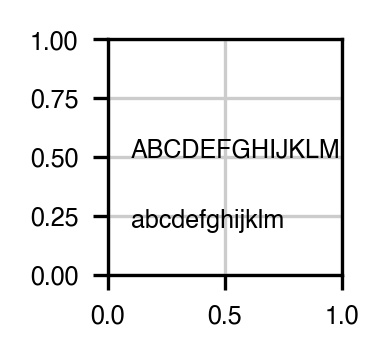

In [6]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

In [7]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

## Loading the data

Here we load the expression matrices and metadata, in anndata files.

In [8]:
adata = anndata.read_loom('../Data/Processed/Mousebrains.loom')

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
adata

AnnData object with n_obs × n_vars = 2210 × 16039
    obs: 'Ambiguity', 'BC', 'CellTypes_Level1', 'CellTypes_Level2', 'CellTypes_Level3', 'CellTypes_Level4_zeisel', 'CellTypes_Level4_zeisel_final', 'Exon', 'Intergenic', 'Intron', 'QC', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.1', 'RNA_snn_res.2', 'Sample_ID', 'Sample_Plate', 'Sample_Plate_BCSet', 'Sample_Well', 'UMIfrac', 'Unmapped', 'User', 'age', 'brain', 'cell_type', 'cellid', 'cloneID', 'condition', 'description', 'layer', 'location', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'nCount_RNA', 'nFeature_RNA', 'nGenes', 'nGenesUMIs', 'nNontagged', 'nUMIs', 'nUMItag', 'n_genes_by_counts', 'nreadpairs', 'obs_names', 'orig.ident', 'pct_counts_mt', 'percent.mito', 'region', 'seurat_clusters', 'sex', 'technology', 'total_counts', 'total_counts_mt'
    var: 'dispersions', 'dispersions_norm', 'highly_variable', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 

Separating data by celltype and brain

In [10]:
celltypes = adata.obs.cell_type.unique()

In [11]:
brains = adata.obs.brain.unique()

In [12]:
ad = {}
datasets = []
for ct in celltypes:
    for brain in brains:
        ds = ct+'_'+brain
        ad[ds] = adata[adata.obs.brain == brain, :]
        ad[ds] = ad[ds][ad[ds].obs.cell_type == ct, :]
        cpops = ad[ds].obs.cloneID.value_counts()
        bigclones = cpops[cpops >= 3].index
        ad[ds] = ad[ds][ad[ds].obs.cloneID.isin(bigclones)]
        K = len(bigclones)
        N = len(ad[ds].obs_names)
        if K >= 2:
            print('Dataset {} added with {} cells in {} clones'.format(ds,N,K))
            datasets.append(ds)
        else:
            print('Not enough cells/clones in {}'.format(ds))
            ad.pop(ds)
        hrule()

Dataset ACTE2DL_brain1 added with 176 cells in 40 clones
Dataset ACTE2DL_brain2 added with 32 cells in 8 clones
Dataset ACTE2UL_brain1 added with 110 cells in 26 clones
Dataset ACTE2UL_brain2 added with 84 cells in 11 clones
Dataset ACTE1_brain1 added with 22 cells in 6 clones
Not enough cells/clones in ACTE1_brain2
Not enough cells/clones in PVM1_brain1
Not enough cells/clones in PVM1_brain2
Dataset MGL1_brain1 added with 15 cells in 2 clones
Dataset MGL1_brain2 added with 97 cells in 2 clones
Dataset TEGLU7_brain1 added with 107 cells in 23 clones
Dataset TEGLU7_brain2 added with 74 cells in 11 clones
Not enough cells/clones in TEGLU3_brain1
Dataset TEGLU3_brain2 added with 9 cells in 3 clones
Dataset TEGLU8_brain1 added with 34 cells in 9 clones
Dataset TEGLU8_brain2 added with 48 cells in 10 clones
Not enough cells/clones in TEGLU12_brain1
Dataset TEGLU12_brain2 added with 15 cells in 4 clones
Not enough cells/clones in TEGLU10_brain1
Not enough cells/clones in TEGLU10_brain2
Not e

In [13]:
print(datasets)

['ACTE2DL_brain1', 'ACTE2DL_brain2', 'ACTE2UL_brain1', 'ACTE2UL_brain2', 'ACTE1_brain1', 'MGL1_brain1', 'MGL1_brain2', 'TEGLU7_brain1', 'TEGLU7_brain2', 'TEGLU3_brain2', 'TEGLU8_brain1', 'TEGLU8_brain2', 'TEGLU12_brain2', 'MOL1_brain2', 'MFOL1_brain2', 'OPC_brain1', 'OPC_brain2', 'COP1_brain1', 'COP1_brain2', 'NFOL1_brain2']


In [14]:
ad['MGL1fake_brain1'] = ad['MGL1_brain1']
ad['MGL1fake_brain2'] = ad['MGL1_brain2'].copy()
M_cells = ad['MGL1fake_brain2'].obs_names
display(ad['MGL1fake_brain2'].obs.cloneID.value_counts())
ad['MGL1fake_brain2'] = ad['MGL1fake_brain2'][np.random.choice(M_cells, 15, replace=False), :]
display(ad['MGL1fake_brain2'].obs.cloneID.value_counts())

259    52
252    45
Name: cloneID, dtype: int64

259    8
252    7
Name: cloneID, dtype: int64

In [15]:
datasets.append('MGL1fake_brain1')
datasets.append('MGL1fake_brain2')

In [16]:
datasets

['ACTE2DL_brain1',
 'ACTE2DL_brain2',
 'ACTE2UL_brain1',
 'ACTE2UL_brain2',
 'ACTE1_brain1',
 'MGL1_brain1',
 'MGL1_brain2',
 'TEGLU7_brain1',
 'TEGLU7_brain2',
 'TEGLU3_brain2',
 'TEGLU8_brain1',
 'TEGLU8_brain2',
 'TEGLU12_brain2',
 'MOL1_brain2',
 'MFOL1_brain2',
 'OPC_brain1',
 'OPC_brain2',
 'COP1_brain1',
 'COP1_brain2',
 'NFOL1_brain2',
 'MGL1fake_brain1',
 'MGL1fake_brain2']

# Adding permuted labels to AnnData objects

We will be running permutation tests to find clonal signals in our data.  For this purpose, we will permute the clone-labels on many of our cells (within each celltype and brain).  

The following is a specialized tool for permutation tests.  It produes permutations which disrupt existing group structures.  For example, if we want 10 permutations of clone labels, we produce 100 permutations instead.  We "score" these by looking at how many distinct labels each old clone receives.  I.e., if an old clone A has three cells 1,2,3, and these are assigned labels B,C,D instead of A,A,A, then we give it a score of 3 (three distinct labels).  We then take the top 10 permutations, by this score.  

This mitigates some issues with clonal structure being preserved by some permutations and not by others... a significant issue when there are pretty small samples.

In [17]:
def make_shuff(meta, no_shuffs=10, topratio = 10):
    tot_shuffs = no_shuffs * topratio
    ms_df = pd.DataFrame(index=meta.index, columns=range(tot_shuffs))
    ms_df = pd.concat([meta.astype(str) for j in range(tot_shuffs)], axis=1)
    
    ms_vals = ms_df.values
    [np.random.shuffle(x) for x in ms_vals.T]
    
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(tot_shuffs)]
    scores = ms_df.groupby(meta).nunique().sum()
    good_shuffs = scores.sort_values()[-no_shuffs:].index
    ms_df = ms_df[good_shuffs].astype('category')
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(no_shuffs)]
    return ms_df

In [18]:
no_shuffs = 1100

for ds in datasets:
    ad[ds].obs['clone_id'] = ad[ds].obs.cloneID.astype(str)
    K = ad[ds].obs.clone_id.nunique()
    clone_shuffs = make_shuff(ad[ds].obs.clone_id, no_shuffs = no_shuffs)
    shuff_cols = clone_shuffs.columns
    ad[ds].obs[shuff_cols] = clone_shuffs
    print('Shuffled clone labels produced for dataset with {} cells and {} clones'.format(ad[ds].shape[0], K))

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 176 cells and 40 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 32 cells and 8 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 110 cells and 26 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 84 cells and 11 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 22 cells and 6 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 15 cells and 2 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 97 cells and 2 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 107 cells and 23 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 74 cells and 11 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 9 cells and 3 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 34 cells and 9 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 48 cells and 10 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 15 cells and 4 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 14 cells and 3 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 28 cells and 8 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 72 cells and 19 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 52 cells and 10 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 12 cells and 3 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 13 cells and 4 clones
Shuffled clone labels produced for dataset with 7 cells and 2 clones


Trying to set attribute `.obs` of view, copying.


Shuffled clone labels produced for dataset with 15 cells and 2 clones
Shuffled clone labels produced for dataset with 15 cells and 2 clones


In [19]:
ad[ds].obs # Scroll right to see shuffled clone labels.

,Ambiguity,BC,CellTypes_Level1,CellTypes_Level2,CellTypes_Level3,CellTypes_Level4_zeisel,CellTypes_Level4_zeisel_final,Exon,Intergenic,Intron,...,Shuffle_1090,Shuffle_1091,Shuffle_1092,Shuffle_1093,Shuffle_1094,Shuffle_1095,Shuffle_1096,Shuffle_1097,Shuffle_1098,Shuffle_1099
952,939,TTCCTCTGTAAACCACTTCC,Immune,immune,Microglia,MGL1,MGL1,32960,8965,7468,...,252,259,252,259,259,252,252,259,259,259
838,5701,CACATCCAGGTACGCATCGG,Immune,immune,Microglia,MGL1,MGL1,262968,53521,37454,...,259,259,259,252,252,252,259,259,259,252
892,8533,TACTTGTGCACCTCTTCCTG,Immune,immune,Microglia,MGL1,MGL1,242600,48649,67788,...,252,259,259,259,259,252,259,252,252,259
914,4306,TCGGTAACACTCTAGAACGG,Immune,immune,Microglia,MGL1,MGL1,177577,26788,23758,...,259,252,259,252,252,252,259,259,259,259
938,9344,TTAATGCCGATACGCATCGG,Immune,immune,Microglia,MGL1,MGL1,334680,56873,78215,...,259,259,259,259,259,259,252,259,252,252
970,4352,TTCTTATCGCATCGCAAGAA,Immune,immune,Microglia,MGL1,MGL1,134299,27947,31018,...,259,259,259,252,259,252,259,259,252,259
887,6054,TACACCTGAATCCTCTCCAA,Immune,immune,Microglia,MGL1,MGL1,156201,26552,39693,...,252,252,252,252,252,259,259,259,259,252
946,9382,TTCAACGGTAACTCGCTTGA,Immune,immune,Microglia,MGL1,MGL1,321103,61786,63778,...,259,259,259,252,259,259,252,259,252,252
880,3863,GGATCTACAAGGAGTGTCCA,Immune,immune,Microglia,MGL1,MGL1,131674,28320,30487,...,252,252,252,259,259,252,259,252,259,259
954,3092,TTCCTTAGCTAACACAAGCG,Immune,immune,Microglia,MGL1,MGL1,117433,32017,29637,...,259,252,252,259,252,259,259,252,259,252


In [20]:
adata.var_names = adata.var['var_names']
for ds in datasets:
    ad[ds].var_names = ad[ds].var['var_names']

In [21]:
from time import time
from scipy.stats import f_oneway

def make_pvals(ad, real_group, shuffle_label = 'Shuffle', no_shuffs=100):
    '''
    Expects an AnnData object ad.
    real_group is usually "cloneID", or the equivalent.
    Also expects a lot of shuffled real_group labels, called
    Shuffle_0, Shuffle_1, up to Shuffle_n, where n = no_shuffs.
    real_group and shuffles should be within the ad.obs dataframe.
    Computes p-values by applying scipy's f_oneway to each column of shuffled labels.
    Vectorized for all genes at once.
    '''
    before = time()    
    cols = [real_group] + [shuffle_label + '_' + str(j) for j in range(no_shuffs)]
    pval_df = pd.DataFrame(columns=cols)

    groups = ad.obs[real_group].unique()
    ad_df = ad.to_df()
    pval_df = ad.obs[cols].apply(lambda col : f_oneway(*[ad_df[col == k] for k in groups])[1])
    pval_df.index = ad.var_names
    after = time()
    print('{:1.0f} seconds to compute ANOVA F p-values for {} cells and {} groups.'.format(after - before,
                                                                                          ad.shape[0], len(groups)))
    return pval_df

In [22]:
all_pvals = {}
for ds in datasets:
    all_pvals[ds] = make_pvals(ad[ds], 'clone_id', no_shuffs = no_shuffs)

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/scipy/stats/stats.py:3709: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


114 seconds to compute ANOVA F p-values for 176 cells and 40 groups.
31 seconds to compute ANOVA F p-values for 32 cells and 8 groups.
79 seconds to compute ANOVA F p-values for 110 cells and 26 groups.
52 seconds to compute ANOVA F p-values for 84 cells and 11 groups.
27 seconds to compute ANOVA F p-values for 22 cells and 6 groups.
28 seconds to compute ANOVA F p-values for 15 cells and 2 groups.
38 seconds to compute ANOVA F p-values for 97 cells and 2 groups.
74 seconds to compute ANOVA F p-values for 107 cells and 23 groups.
42 seconds to compute ANOVA F p-values for 74 cells and 11 groups.
14 seconds to compute ANOVA F p-values for 9 cells and 3 groups.
33 seconds to compute ANOVA F p-values for 34 cells and 9 groups.
35 seconds to compute ANOVA F p-values for 48 cells and 10 groups.
15 seconds to compute ANOVA F p-values for 15 cells and 4 groups.
19 seconds to compute ANOVA F p-values for 14 cells and 3 groups.
29 seconds to compute ANOVA F p-values for 28 cells and 8 groups.
5

In [23]:
for ds in datasets:
    all_pvals[ds].index = ad[ds].var_names

In [24]:
all_pvals[ds]

,clone_id,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_1090,Shuffle_1091,Shuffle_1092,Shuffle_1093,Shuffle_1094,Shuffle_1095,Shuffle_1096,Shuffle_1097,Shuffle_1098,Shuffle_1099
var_names,,,,,,,,,,,,,,,,,,,,,
EGFP,0.027873,0.798998,0.903163,0.183243,0.642134,0.302594,0.968152,0.660244,0.882308,0.717669,...,0.626604,0.187769,0.774045,0.962533,0.118730,0.684616,0.512970,0.436572,0.371853,0.985660
Gnai3,0.310203,0.173062,0.603283,0.051753,0.588743,0.523810,0.385836,0.570214,0.173062,0.434383,...,0.482463,0.296887,0.309069,0.663941,0.128230,0.981007,0.841254,0.296887,0.663941,0.128230
Cdc45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Narf,0.710038,0.383319,0.810626,0.280430,0.006493,0.856996,0.945521,0.140419,0.876906,0.788707,...,0.969195,0.000167,0.736655,0.540912,0.769236,0.723371,0.079773,0.011007,0.188425,0.616904
Cav2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC161763.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC126250.1,0.920613,0.124292,0.776833,0.124292,0.920613,0.776833,0.776833,0.920613,0.124292,0.920613,...,0.183742,0.920613,0.183742,0.776833,0.183742,0.776833,0.920613,0.920613,0.776833,0.183742
AC132863.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
mm = 1 / 25.4

In [26]:
print(datasets)
celltypes = list(pd.Series([ds.split('_')[0] for ds in datasets]).unique())
print(celltypes)

['ACTE2DL_brain1', 'ACTE2DL_brain2', 'ACTE2UL_brain1', 'ACTE2UL_brain2', 'ACTE1_brain1', 'MGL1_brain1', 'MGL1_brain2', 'TEGLU7_brain1', 'TEGLU7_brain2', 'TEGLU3_brain2', 'TEGLU8_brain1', 'TEGLU8_brain2', 'TEGLU12_brain2', 'MOL1_brain2', 'MFOL1_brain2', 'OPC_brain1', 'OPC_brain2', 'COP1_brain1', 'COP1_brain2', 'NFOL1_brain2', 'MGL1fake_brain1', 'MGL1fake_brain2']
['ACTE2DL', 'ACTE2UL', 'ACTE1', 'MGL1', 'TEGLU7', 'TEGLU3', 'TEGLU8', 'TEGLU12', 'MOL1', 'MFOL1', 'OPC', 'COP1', 'NFOL1', 'MGL1fake']


In [27]:
import matplotlib.patches as patches

In [56]:
def permplot(celltype, brain, pcut=0.01):
    figsize = (45*mm, 30*mm)
    sns.set_style('white', rc={"axes.facecolor": (0, 0, 0, 0)})
    setfontsize()
    fig,ax = plt.subplots(1,1, figsize=figsize, dpi=300)
    ds = celltype+'_'+brain
    if ds in datasets:
        num_sig = (all_pvals[ds] < pcut).sum()
        sig_med = num_sig.drop('clone_id').median()
        sig_high = num_sig.drop('clone_id').quantile(0.95)
        nsig = num_sig['clone_id']
        N = len(ad[ds])
        K = ad[ds].obs.cloneID.nunique()
            
        sns.kdeplot(num_sig.drop('clone_id'), clip_on=False, shade=True, 
                    alpha=0.4, ax=ax, legend=False)
        sns.kdeplot(num_sig.drop('clone_id'), clip_on=False, color='w', 
                    alpha=1, ax=ax, legend=False)
        kde_curve = ax.lines[0]
        kde_y = kde_curve.get_ydata()
        ky_max = kde_y.max()
        ax.set_yticks([])
        ax.set_title('')
        ax.set_ylim(0,ky_max*2)
            
        ax.text(0.01, 0.85, '{}, Brain {}'.format(celltype,brain[-1],N,K), fontweight="bold", 
                       color='black', ha="left", va="center", transform=ax.transAxes)
            
        ax.axvline(nsig, ymax=0.3, color='red')
        ax.axvline(sig_med, ymax=0.3, linewidth=0.5, color='blue')
        ax.axvline(sig_high, ymax=0.3, linewidth=0.5, color='orange')
        trans = ax.get_xaxis_transform()
        ax.text(0.01, .75, 'N={}, K={}.'.format(N,K), fontweight="bold", 
                    color='black', ha="left", va="center", transform=ax.transAxes)
            
        ax.text(0.01, .65, '{:d} excess clonal genes.'.format(int(nsig - sig_med)),  
                color='black', ha="left", va="center", transform=ax.transAxes)
            
            #ax[i].text(nsig, 0.2, '{} \n sig. genes'.format(nsig), color=(0.5,0,0), 
            #           ha='center', va='bottom', transform=trans)
            
        ar_y = ky_max * 0.45
        arr = patches.FancyArrowPatch((sig_med, ar_y), (nsig, ar_y), arrowstyle='<->', 
                                        shrinkA=0, shrinkB=0,
                                        mutation_scale=5, linewidth=0.5, color='k', zorder=10)
        ax.add_patch(arr)
            
        if nsig > (sig_high+20):
            ax.text(0.01, .55, '{:d} beyond 95th percentile.'.format(int(nsig - sig_high)),  
                    color='black', ha="left", va="center", transform=ax.transAxes)
            arr = patches.FancyArrowPatch((sig_high, ar_y*0.7), (nsig, ar_y*0.7), arrowstyle='<->', 
                                          shrinkA=0, shrinkB=0,
                                          mutation_scale=5, linewidth=0.5, color='k', zorder=10)
            ax.add_patch(arr)
                
        ax.set_xlabel('')
        ax.set_ylabel('Density')
        ax.tick_params(axis='x', pad=-1)
        sns.despine()
        set_size(fig, figsize)
        plt.savefig('Panels/{}_excess_genes.pdf'.format(ds), bbox_inches='tight')
        plt.show()

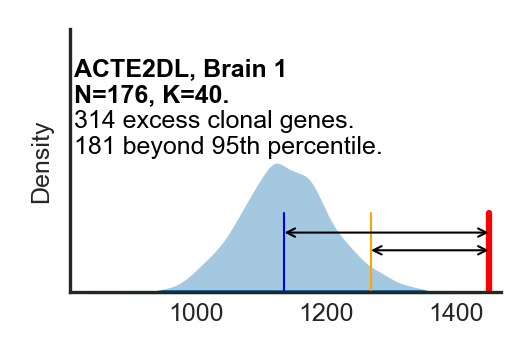

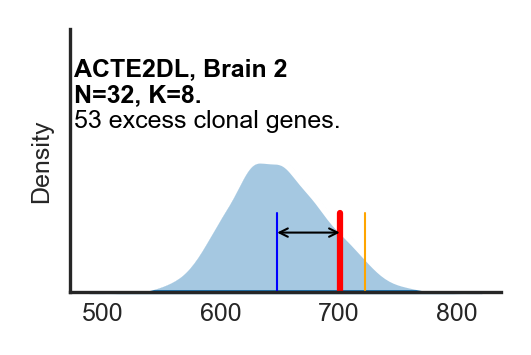

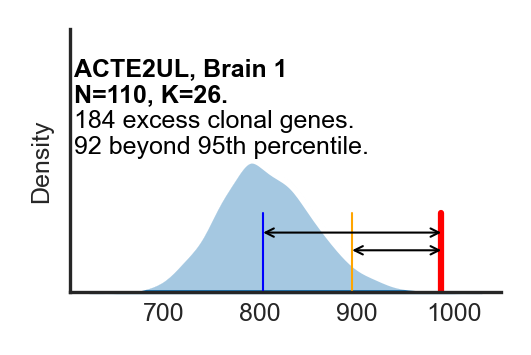

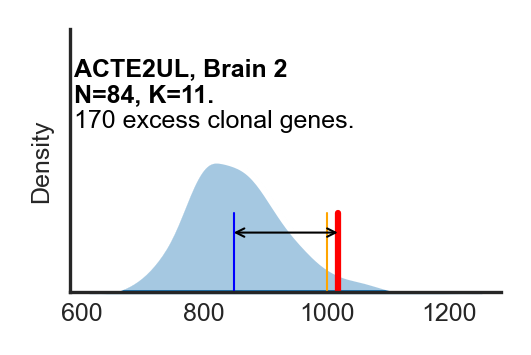

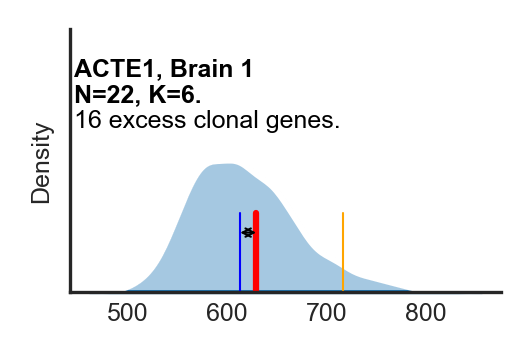

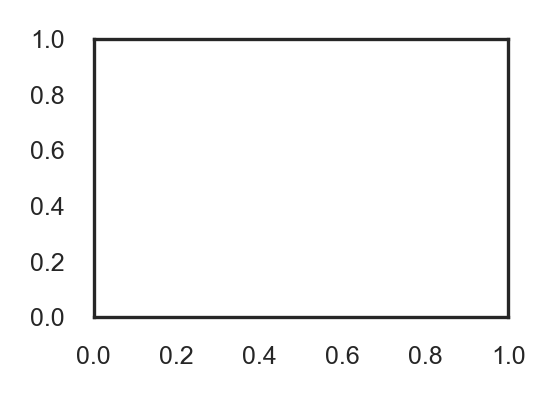

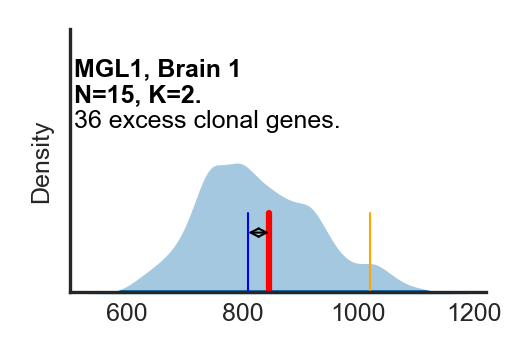

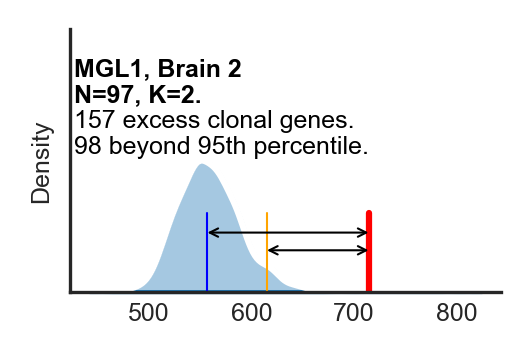

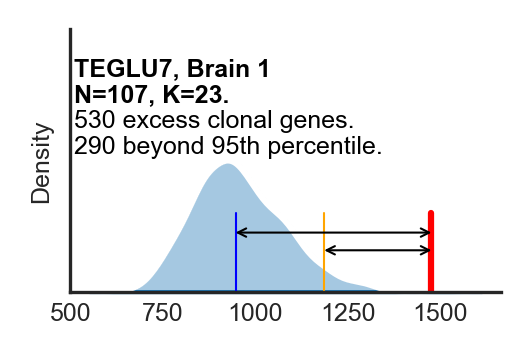

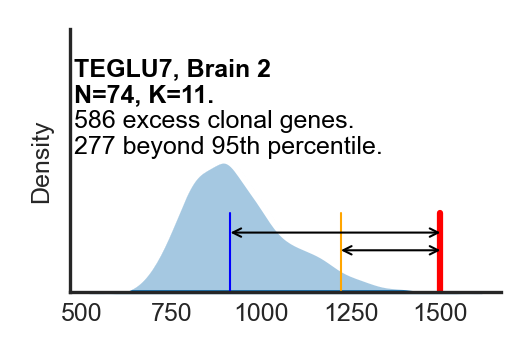

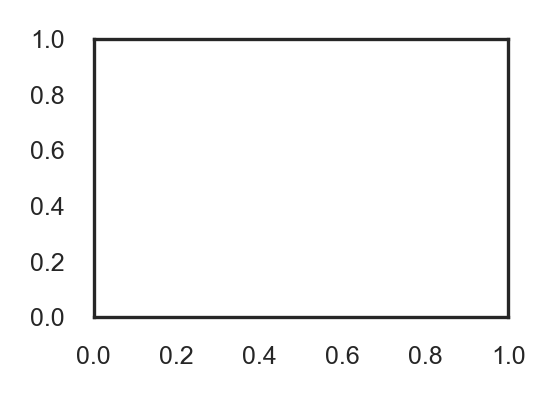

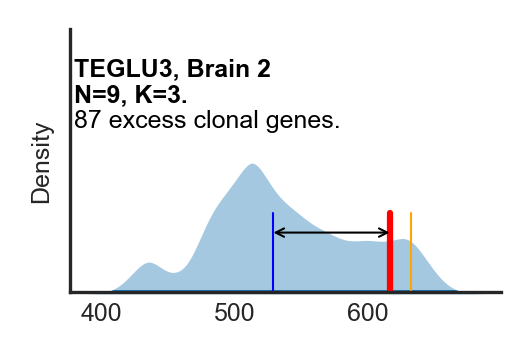

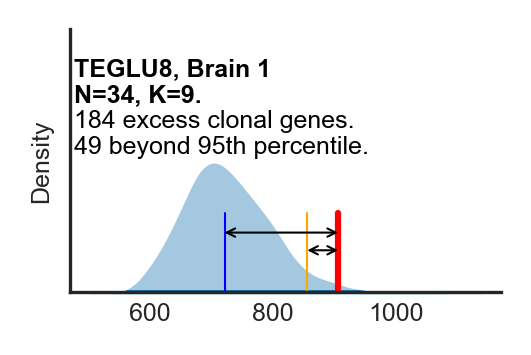

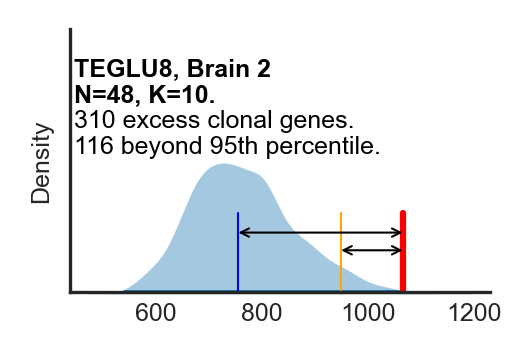

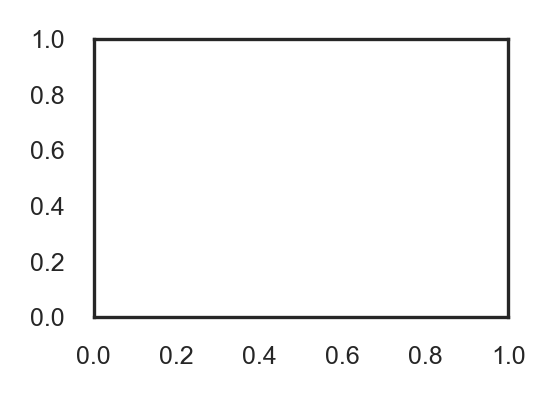

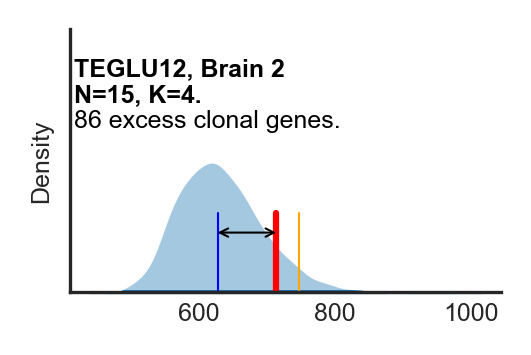

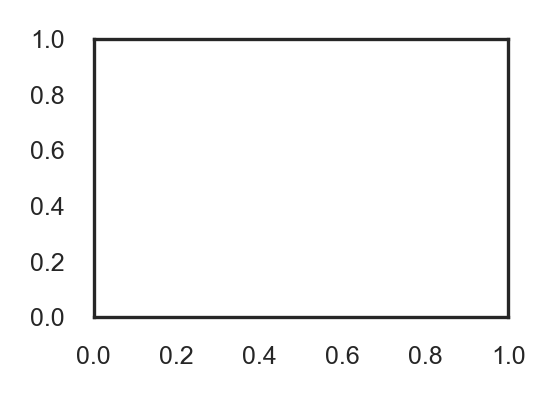

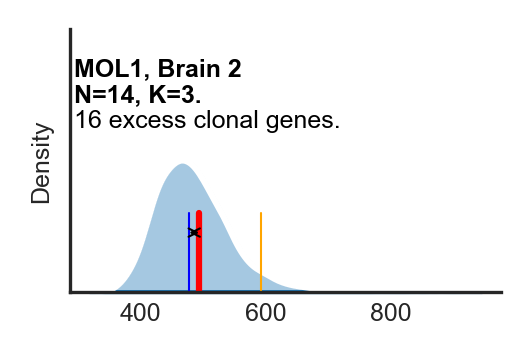

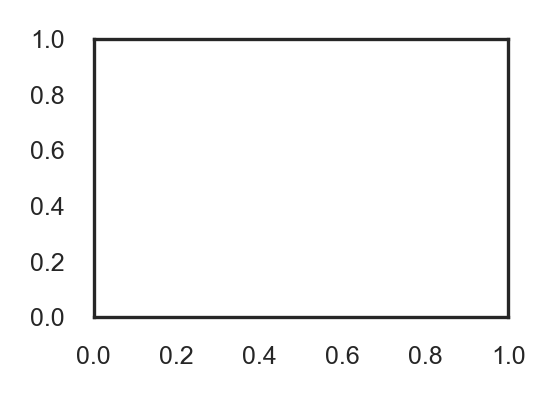

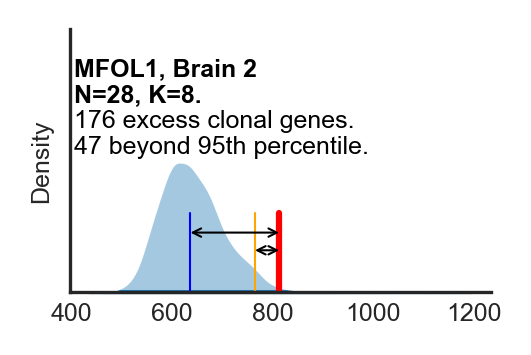

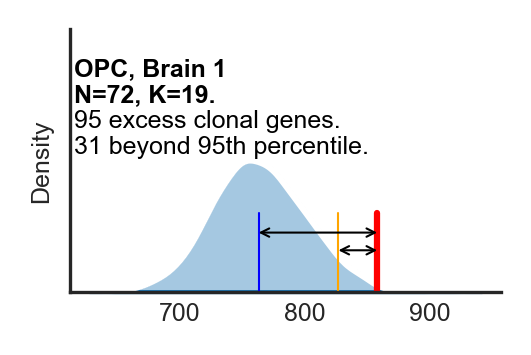

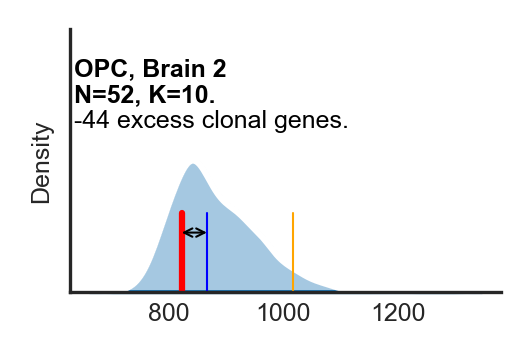

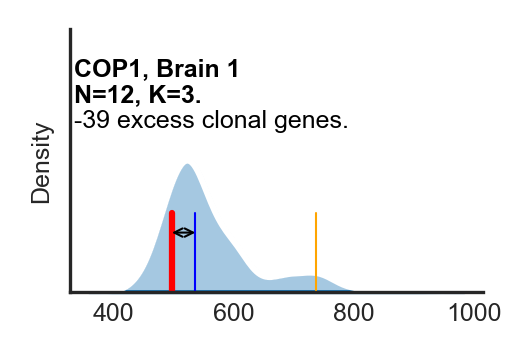

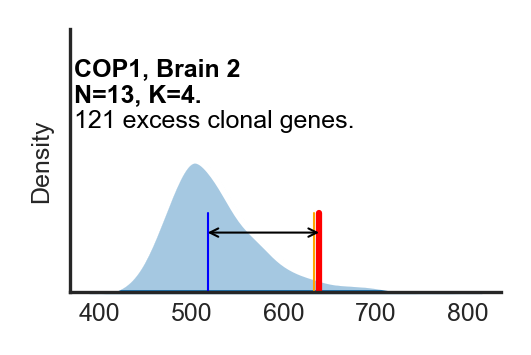

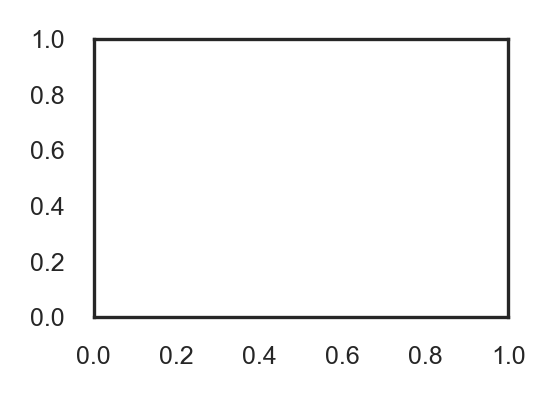

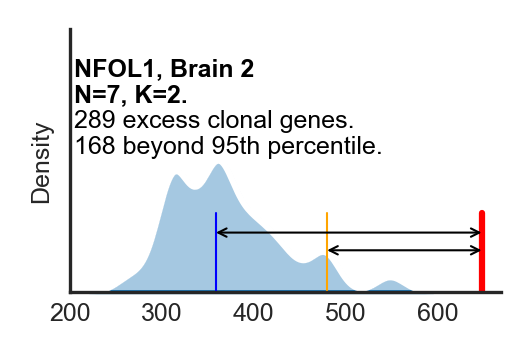

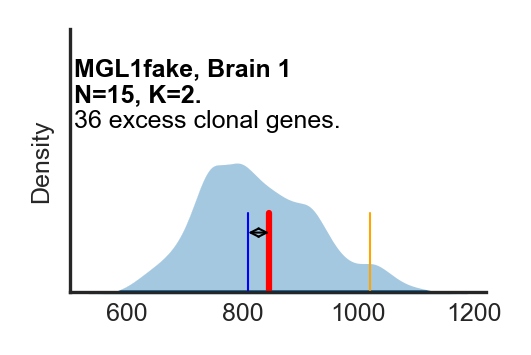

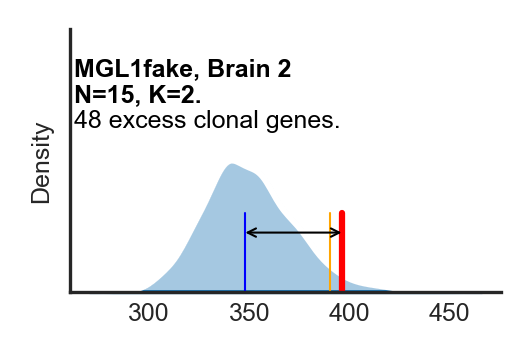

In [58]:
for ct in celltypes:
    for brain in brains:
        permplot(ct, brain, pcut=0.05)

In [30]:
psummary = pd.DataFrame(columns = ['N','K','far_excess_sig','excess_sig','nsig','sig_med','sig_high'], index=datasets)

for brain in brains:
    for celltype in celltypes:
        ds = celltype+'_'+brain
        if ds in datasets:
            num_sig = (all_pvals[ds] < 0.05).sum()
            psummary.loc[ds,'N'] = len(ad[ds])
            psummary.loc[ds,'K'] = ad[ds].obs.cloneID.nunique()
            psummary.loc[ds,'nsig'] = num_sig['clone_id']
            psummary.loc[ds,'sig_med'] = np.ceil(num_sig.drop('clone_id').median()).astype(int)
            psummary.loc[ds,'sig_high'] = np.ceil(num_sig.drop('clone_id').quantile(0.95)).astype(int)
            psummary.loc[ds,'excess_sig'] = psummary.loc[ds,'nsig'] - psummary.loc[ds,'sig_med']
            psummary.loc[ds,'far_excess_sig'] = psummary.loc[ds,'nsig'] - psummary.loc[ds,'sig_high']
            if psummary.loc[ds,'nsig'] < psummary.loc[ds,'sig_high']:
                psummary.drop(ds, inplace=True)

In [31]:
psummary

,N,K,far_excess_sig,excess_sig,nsig,sig_med,sig_high
ACTE2DL_brain1,176,40,181,314,1450,1136,1269
ACTE2UL_brain1,110,26,92,184,987,803,895
ACTE2UL_brain2,84,11,17,170,1018,848,1001
MGL1_brain2,97,2,98,157,714,557,616
TEGLU7_brain1,107,23,290,530,1477,947,1187
TEGLU7_brain2,74,11,277,586,1501,915,1224
TEGLU8_brain1,34,9,49,184,906,722,857
TEGLU8_brain2,48,10,116,310,1065,755,949
MFOL1_brain2,28,8,47,176,813,637,766
OPC_brain1,72,19,31,95,858,763,827


## Identifying clonal genes

We use the permuted clone labels together with the ANOVA F p-values to identify clonal genes while managing false discovery rate.

In [30]:
for ds in datasets:
    ad[ds].var['nz_ratio'] = (ad[ds].to_df() > 0).sum() / ad[ds].n_obs

In [31]:
3 / len(ad[ds])

0.42857142857142855

In [32]:
for ds in datasets:
    genes_before = ad[ds].var_names
    goodgenes = ad[ds].var['nz_ratio'] >= max(0.05, 3 / len(ad[ds]))
    goodgenes = goodgenes[goodgenes].index
    ad[ds] = ad[ds][:,goodgenes]
    genes_after = ad[ds].var_names
    print('{} genes removed for rare expression.'.format(len(genes_before) - len(genes_after)))

2574 genes removed for rare expression.
3855 genes removed for rare expression.
2596 genes removed for rare expression.
2865 genes removed for rare expression.
4795 genes removed for rare expression.
9341 genes removed for rare expression.
5070 genes removed for rare expression.
1373 genes removed for rare expression.
1266 genes removed for rare expression.
4941 genes removed for rare expression.
2153 genes removed for rare expression.
1486 genes removed for rare expression.
3714 genes removed for rare expression.
6248 genes removed for rare expression.
4160 genes removed for rare expression.
2887 genes removed for rare expression.
2791 genes removed for rare expression.
6501 genes removed for rare expression.
6179 genes removed for rare expression.
8081 genes removed for rare expression.


In [33]:
ad[ds].var['nz_ratio'].describe()

count    7958.000000
mean        0.748806
std         0.211109
min         0.428571
25%         0.571429
50%         0.714286
75%         1.000000
max         1.000000
Name: nz_ratio, dtype: float64

In [34]:
shuff_cols = ['Shuffle_'+str(j) for j in range(1000)]
test_cols = ['clone_id'] + ['Shuffle_'+str(j) for j in range(1000,1100)]

In [35]:
def adj_pval_binned(ad, pv, test_cols, shuff_cols, bins=20, corrected=True, verbose=False):
    nz_cut = pd.qcut(ad.var.nz_ratio, bins, duplicates='drop')
    p_adj_list = []
    for nz_bin in nz_cut.unique():
        if verbose:
            print('Processing genes with nonzero ratio in {}'.format(nz_bin))
        genes_bin = nz_cut[nz_cut == nz_bin].index
        bin_pvals = pv.loc[genes_bin]
        shuff_pvals = bin_pvals[shuff_cols]
        now_time = time()
        shuff_pvals = np.sort(shuff_pvals, axis=None)
        then_time = time()
        if verbose:
            print('Sorting {} p-values took {} seconds.'.format(len(shuff_pvals), then_time - now_time))
        test_pvals = bin_pvals[test_cols].values
        now_time = time()
        places = np.searchsorted(shuff_pvals, test_pvals )
        then_time = time()
        if verbose:
            print('Finding places for {} p-values in sorted list took {} seconds.'.format(test_pvals.shape, 
                                                                                         then_time-now_time))
        denominator = 1 + len(shuff_pvals)
        numerator = 1 + places
        p_adj = pd.DataFrame(numerator / denominator, index=bin_pvals.index, columns=test_cols)
        if corrected:
            corrector = test_pvals.shape[0]
            p_adj = (p_adj * corrector).clip(0,1)
        p_adj_list.append(p_adj)
    return pd.concat(p_adj_list)

In [36]:
p_permadj = {}
for ds in datasets:
    print('Adjusting p-values for {}'.format(ds))
    p_permadj[ds] = adj_pval_binned(ad[ds], all_pvals[ds], test_cols, shuff_cols, corrected=True)

Adjusting p-values for ACTE2DL_brain1
Adjusting p-values for ACTE2DL_brain2
Adjusting p-values for ACTE2UL_brain1
Adjusting p-values for ACTE2UL_brain2
Adjusting p-values for ACTE1_brain1
Adjusting p-values for MGL1_brain1
Adjusting p-values for MGL1_brain2
Adjusting p-values for TEGLU7_brain1
Adjusting p-values for TEGLU7_brain2
Adjusting p-values for TEGLU3_brain2
Adjusting p-values for TEGLU8_brain1
Adjusting p-values for TEGLU8_brain2
Adjusting p-values for TEGLU12_brain2
Adjusting p-values for MOL1_brain2
Adjusting p-values for MFOL1_brain2
Adjusting p-values for OPC_brain1
Adjusting p-values for OPC_brain2
Adjusting p-values for COP1_brain1
Adjusting p-values for COP1_brain2
Adjusting p-values for NFOL1_brain2


In [38]:
sig_genes = {}
for ds in psummary.index:
    sig_df = (p_permadj[ds] < 0.1)
    #print(ds, sig_df.sum())
    sig_genes[ds] = list(sig_df.clone_id[sig_df.clone_id].index)
    sig_genes[ds].sort()
    if len(sig_genes[ds]) > 0:
        print('The {} significant genes for {} are {}'.format(len(sig_genes[ds]), ds, ', '.join(sig_genes[ds])))
        FDs = sig_df.sum()[1:].mean()
        print('{} expected by chance.'.format(FDs))
        hrule()

The 9 significant genes for ACTE2DL_brain1 are Arfgap3, Erdr1, Gm26582, Gm42047, Gpm6a, Islr, Mfge8, Spice1, Xlr3b
2.27 expected by chance.
The 11 significant genes for ACTE2UL_brain1 are Chrdl1, Dclk1, EGFP, Gm21887, Gm42047, Hspa8, Lig1, Map1s, Slco1c1, Txn1, Xlr3b
2.04 expected by chance.
The 7 significant genes for ACTE2UL_brain2 are 4930488L21Rik, Fam212b, Gm21887, Gpm6a, Rnf149, Syndig1, Xlr3b
2.13 expected by chance.
The 18 significant genes for MGL1_brain2 are 0610030E20Rik, Adcy8, Aldh7a1, Apobr, Apoe, Cd200r1, Ctsb, Cx3cr1, EGFP, Fnta, Gnb4, Igfbp4, Mpeg1, Ptprm, Rab27a, Rps2-ps6, Syngr1, Ttn
2.16 expected by chance.
The 29 significant genes for TEGLU7_brain1 are 6530409C15Rik, A2ml1, Car4, Cntn5, Cpne8, D3Ertd254e, EGFP, Epha6, Erdr1, Gm14296, Gm21887, Gm37297, Gpm6b, Lmo4, Lpl, Lsamp, Myh6, Ncald, Olfm1, Pde1a, Pitpnc1, Plekha6, Ppfibp2, Ptn, Tenm2, Tmem215, Tnc, Tuba4a, Xist
1.95 expected by chance.
The 17 significant genes for TEGLU7_brain2 are 1110046J04Rik, 4833413G10Ri

In [39]:
psummary

,N,K,far_excess_sig,excess_sig,nsig,sig_med,sig_high
ACTE2DL_brain1,176,40,185,311,1450,1139,1265
ACTE2UL_brain1,110,26,96,186,987,801,891
ACTE2UL_brain2,84,11,22,176,1018,842,996
MGL1_brain2,97,2,101,156,714,558,613
TEGLU7_brain1,107,23,293,531,1477,946,1184
TEGLU7_brain2,74,11,289,584,1501,917,1212
TEGLU8_brain1,34,9,43,183,906,723,863
TEGLU8_brain2,48,10,132,312,1065,753,933
MFOL1_brain2,28,8,31,187,813,626,782
OPC_brain1,72,19,32,97,858,761,826


KeyError: 'Xlr3b'

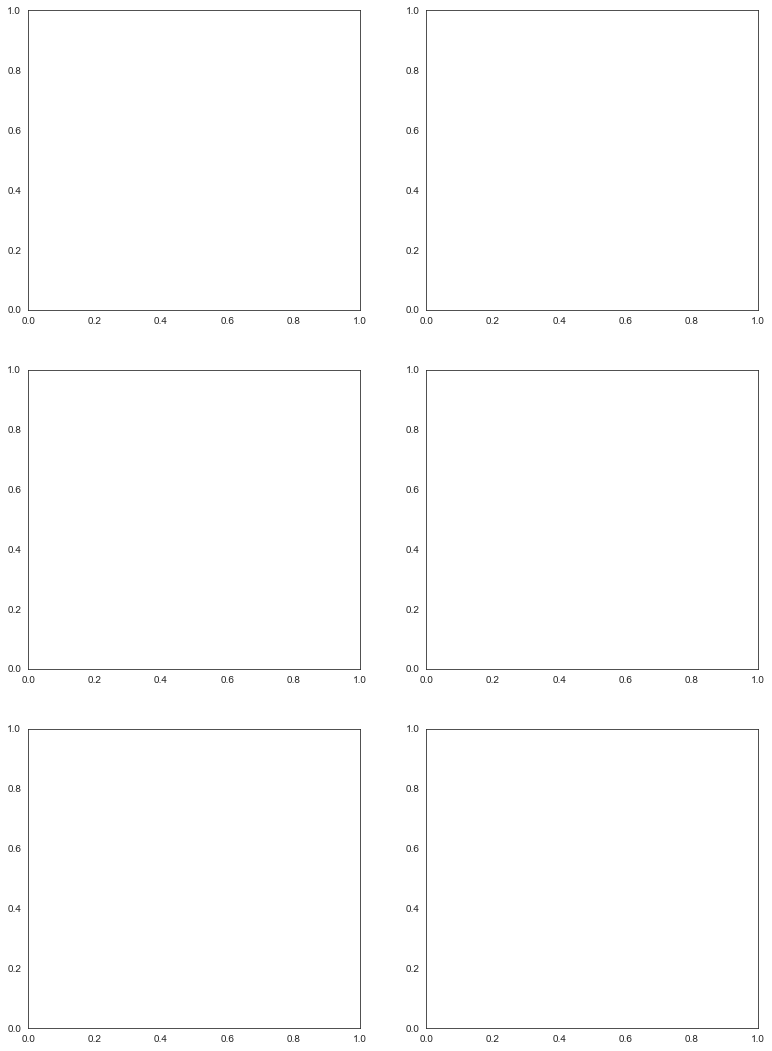

In [312]:
n_components = 10
n_neighbors = 5
min_dist = 0.25
fig, ax = plt.subplots(3,2, figsize=(13,18))
desetfontsize()
sns.set_style('white')
for j,ds in enumerate(['TEGLU7_brain1','TEGLU7_brain2']):
    X = ad[ds].to_df()[sig_genes[ds]]
    y = ad[ds].obs.clone_id
    pca = PCA(n_components=n_components)
    #X_pca = pca.fit_transform(X) # Apply PCA with 20 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = y.values
    cl_df['EGFP'] = X['EGFP']
    cl_df['Xlr3b'] = X['Xlr3b']
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df, 
                        edgecolor='k', ax=ax[0,j], s=80, legend=True)
    
    if j == 0:
        g.legend(loc='center left', bbox_to_anchor=(-0.25, 0.5), ncol=2)
    else:
        g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
    
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='EGFP', data = cl_df, 
                        edgecolor='k', ax=ax[1,j], s=80)
    
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Xlr3b', data = cl_df, 
                        edgecolor='k', ax=ax[2,j], s=80)

    
    #

    ax[0,j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'from {}.'.format(X.shape[0], X.shape[1], ds))


plt.show()

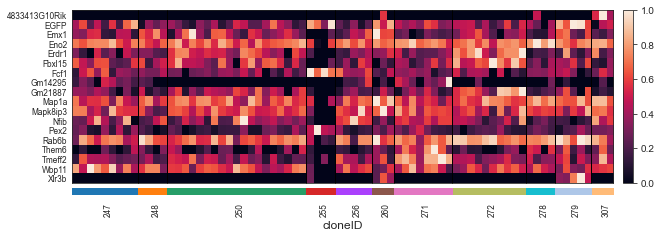

In [300]:
sc.pl.heatmap(ad[ds], sig_genes[ds], groupby='cloneID', swap_axes=True, standard_scale='var')

In [306]:
sig_TEGLU7 = list(set(sig_genes['TEGLU7_brain1']) | set(sig_genes['TEGLU7_brain2']))


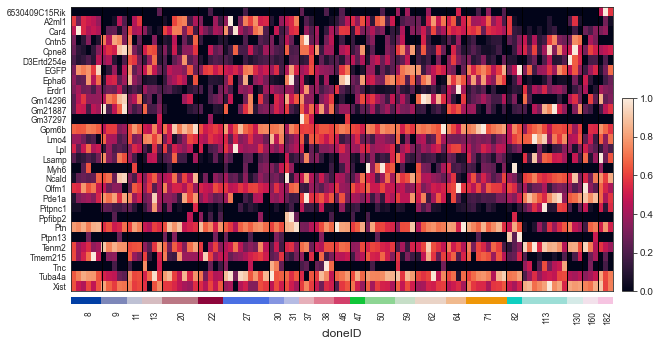

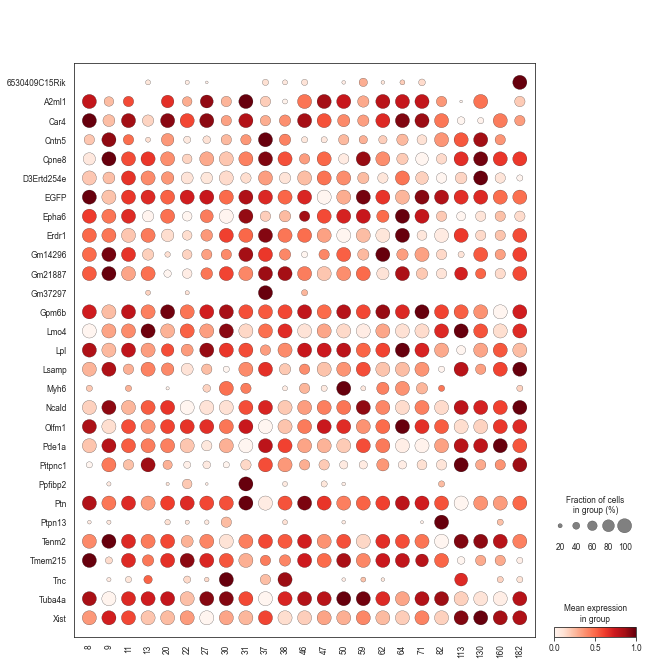

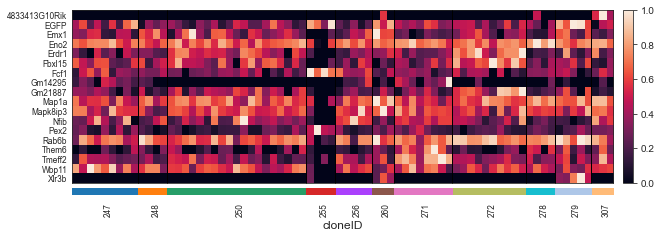

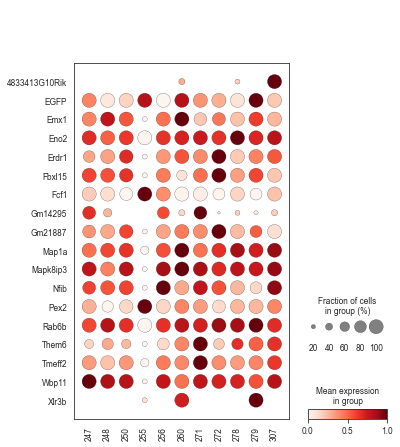

In [309]:
for ds in ['TEGLU7_brain1','TEGLU7_brain2']:
    sc.pl.heatmap(ad[ds], sig_genes[ds], groupby='cloneID', swap_axes=True, standard_scale='var')
    sc.pl.dotplot(ad[ds], sig_genes[ds], groupby='cloneID', swap_axes=True, standard_scale='var')

In [330]:
TEGLUs = [ds for ds in datasets if 'TEGLU' in ds]
TEGLUs

['TEGLU7_brain1',
 'TEGLU7_brain2',
 'TEGLU3_brain2',
 'TEGLU8_brain1',
 'TEGLU8_brain2',
 'TEGLU12_brain2']

In [336]:
psummary

,N,K,far_excess_sig,excess_sig,nsig,sig_med,sig_high
ACTE2DL_brain1,176,40,181,316,1450,1134,1269
ACTE2UL_brain1,110,26,93,182,987,805,894
ACTE2UL_brain2,84,11,4,175,1018,843,1014
MGL1_brain2,97,2,102,157,714,557,612
TEGLU7_brain1,107,23,276,531,1477,946,1201
TEGLU7_brain2,74,11,283,580,1501,921,1218
TEGLU8_brain1,34,9,42,185,906,721,864
TEGLU8_brain2,48,10,126,308,1065,757,939
MFOL1_brain2,28,8,53,181,813,632,760
OPC_brain1,72,19,33,96,858,762,825


In [96]:
def minivio(gene, ad_vio, filename=None):
    plot_df = pd.DataFrame(index=ad_vio.obs_names)
    plot_df[gene] = ad_vio.to_df()[gene] 
    plot_df['Clone'] = ad_vio.obs.cloneID
    plot_df['Noclone'] = 'All'
    #plot_df_noclone = plot_df.copy()
    #plot_df_noclone['Clone'] = 'All'

    #create a figure
    sns.set_style('whitegrid')
    figsize = (30*mm, 20*mm)
    fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[4,1],
                                     'wspace':0.05})
    setfontsize()
    ax[0].tick_params(axis='both', which='major', pad=-2)
    sns.violinplot(x='Clone', y=gene, inner=None, scale='width', data=plot_df, alpha=0.2, 
                   color='lightgray', linewidth=0.4, cut=0, ax=ax[0])
    sns.swarmplot(x='Clone', y=gene, data=plot_df, size=1.5, ax=ax[0])
    ax[0].set_ylim((max(plot_df[gene].min() - 0.25,0), plot_df[gene].max() + 0.25))
    
    sns.violinplot(x='Noclone', y=gene, data=plot_df, color='lightgray', width=1,
                   inner=None, saturation=0.8, linewidth=0.4, cut=0, ax=ax[1])
    sns.swarmplot(x='Noclone', y=gene, data=plot_df, color='gray', size=1.0, ax=ax[1])
    
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[0].tick_params(axis='both', which='major', pad=-1)
    
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    plt.suptitle('{}'.format(gene), y=1.05)
    if filename:
        set_size(fig, figsize)
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [97]:
vio_prefix = 'Panels/MouseViolins/'

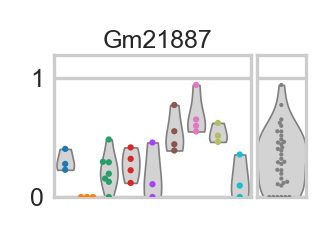

In [110]:
gene = 'Gm21887'
ds = 'TEGLU8_brain1'
minivio(gene, ad[ds], filename=vio_prefix+'{}_{}.pdf'.format(ds,gene))

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


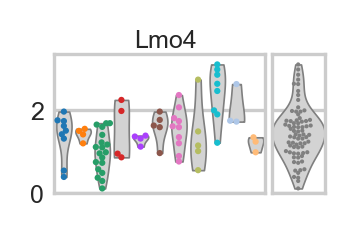

In [107]:
gene = 'Lmo4'
ds = 'TEGLU7_brain2'
minivio(gene, ad[ds], filename=vio_prefix+'{}_{}.pdf'.format(ds,gene))

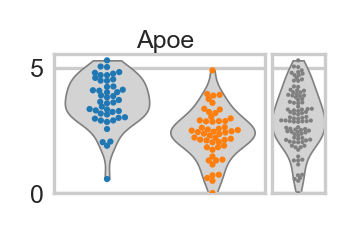

In [85]:
gene = 'Apoe'
ds = 'MGL1_brain2'
minivio(gene, ad[ds], filename=vio_prefix+'{}_{}.pdf'.format(ds,gene))

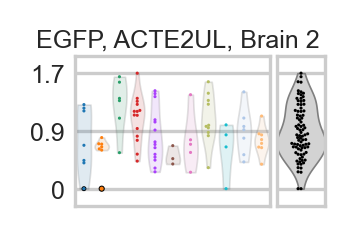

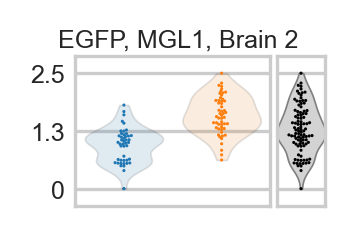

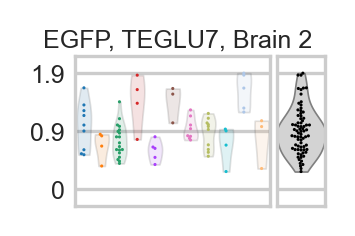

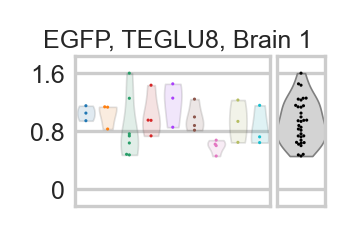

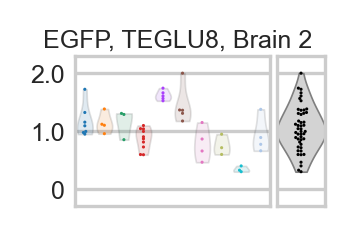

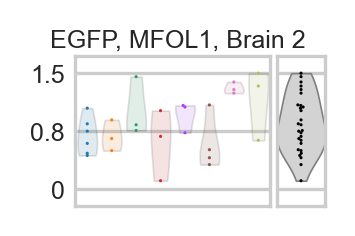

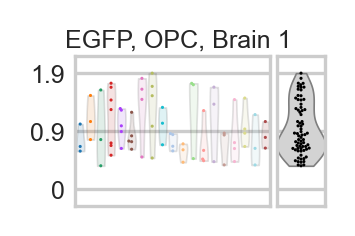

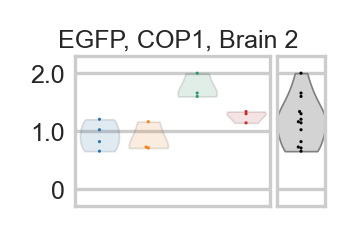

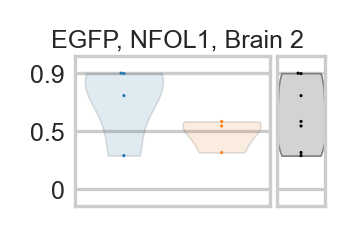

In [362]:
for ds in datasets:
    if ds in psummary.index:
        if psummary.loc[ds,'K'] < 20:
            minivio('EGFP', ad[ds], hide_clones=True, filename=vio_prefix+'{}_{}.pdf'.format(ds,'Gm21887'))

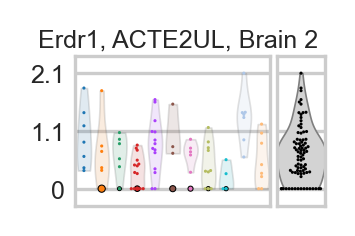

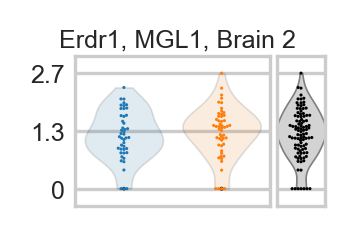

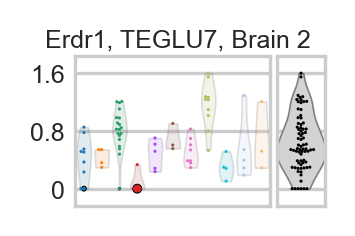

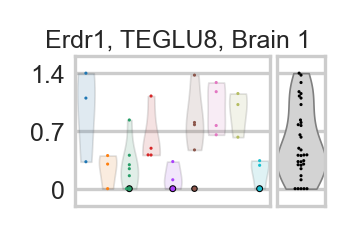

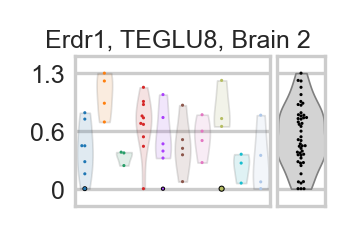

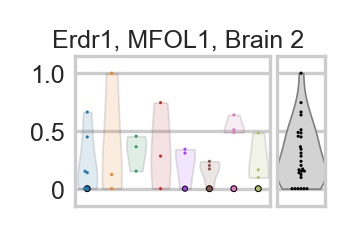

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


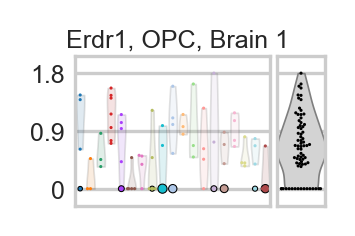

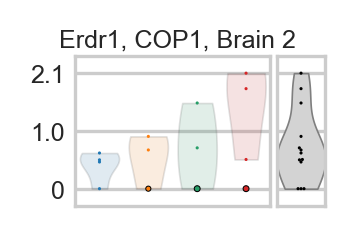

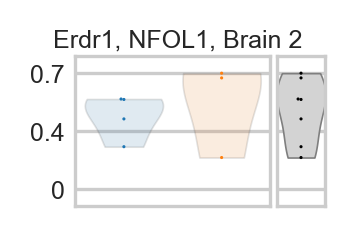

In [349]:
for ds in datasets:
    if ds in psummary.index:
        if psummary.loc[ds,'K'] < 20:
            minivio('Erdr1', ad[ds], hide_clones=True, filename=vio_prefix+'{}_{}.pdf'.format(ds,'Erdr1'))

In [89]:
MGs = [ds for ds in datasets if ('MG' in ds and 'fake' not in ds)]
MGs

['MGL1_brain1', 'MGL1_brain2']

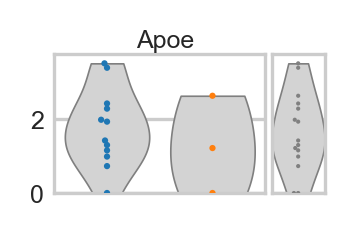

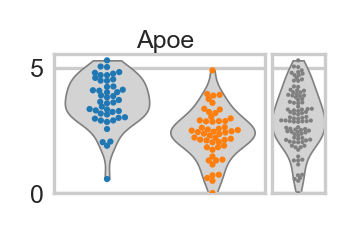

In [90]:
gene = 'Apoe'
for ds in MGs:
    filename=vio_prefix+'{}_{}.pdf'.format(ds,gene)
    minivio(gene,ad[ds], filename=filename)